 # Advanced Machine Learning - programming assignment 2

*Due: Friday December 12th 23:59*

**Please fill in:**
* name 1 (student id 1)
* name 2 (student id 2)

### Further instructions:
* Code quality is considered during the assessment (of ass 2 & 4). Make sure your code is properly commented. 
* Submit your code in BrightSpace only for ass 2 & 4.
* When you submit the code, make sure to name the submitted file according to your and your collaborators last name (i.e. submitter_collaborator.ipynb).
* Please notice that the grader most likely won't install additional packages. Try to stick with the standard library and the packages listed. 
* **Failure to follow these instructions can affect the assignment grade.**

 ## Reinforcement learning with function approximation

In this assignment, you'll design your own agent to complete an episodic MDP task following the gymnasium framework. The agent will be looking at a small part of the UU logo, and have to decide which of the four compass directions (i.e. left, right, up, down) to move in. The learning task is to find the goal in the center as soon as possible.

The learning objectives of this assignment are:
- Implement two versions of the agent using Semi-gradient SARSA and Q-Learning algorithms with a linear approximation function,
- Implement one agent using DQN algorithm (one deep RL method),
- Demonstrate the difference between on-policy and off-policy RL methods,
- Learn to integrate the approximation function with Tabular RL methods,
- Play with the important parameters, e.g. discount factor $\gamma$, stepsize $\alpha$ and update frequency in DQN; and understand their influence on the learning procedure.  


### 1. Let's start with setting up the enviroment.

The following code defines various aspects of the environment.

In [1]:
import itertools as it
from abc import ABC, abstractmethod
from collections import deque
from enum import IntEnum
import random
from typing import List, Tuple

import numpy as np
import pandas as pd
from scipy import stats


import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium
from gymnasium import spaces

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from matplotlib.patches import Patch

from IPython import display
from IPython.display import HTML
from tqdm import tqdm

In [2]:
# %matplotlib inline
# Constants defining the environment
GOAL = (140, 120)
CENTER = (132, 132)
AVG_MOVEMENT_SIZE = 24
ACCEPTABLE_DISTANCE_TO_GOAL = (AVG_MOVEMENT_SIZE // 2) + 1
RADIUS = 72
WINDOW_SIZE = 28
TIME_LIMIT = 200
TIMEOUT_REWARD = -100.0
MOVE_REWARD = -1
INVALID_MOVE_REWARD = -5


# This is for type inference
State = Tuple[int, int]


# Action space
class Actions(IntEnum):
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3


# Boundaries
class Boundary(IntEnum):
    WEST = CENTER[0] - RADIUS
    EAST = CENTER[0] + RADIUS
    NORTH = CENTER[1] - RADIUS
    SOUTH = CENTER[1] + RADIUS

# Augmented boundarie, not used in this assignment
class AugmentedArea(IntEnum):
    WEST = Boundary.WEST - (WINDOW_SIZE // 2)
    EAST = Boundary.EAST + (WINDOW_SIZE // 2)
    NORTH = Boundary.NORTH - (WINDOW_SIZE // 2)
    SOUTH = Boundary.SOUTH + (WINDOW_SIZE // 2)


# Image
ORIGINAL_IMAGE = plt.imread("UU_LOGO.png")
# Convert to one color channel (using only the red channel), with white background
IMAGE = ORIGINAL_IMAGE[:, :, 0] * ORIGINAL_IMAGE[:, :, 3] + (1.0 - ORIGINAL_IMAGE[:, :, 3])


# Get a "camera view" at the position indicated by state
# Use reshape=True to format the output as a data point for the neural network
def get_window(state: State, reshape=False) -> np.ndarray:
    # When indexing the image as an array, switch the coordinates: im[state[1], state[0]]
    window = IMAGE[(state[1] - 14):(state[1] + 14), (state[0] - 14):(state[0] + 14)]
    if reshape:
        return np.reshape(window, (1, 28, 28, 1))
    return window


# Is the state close enough to the goal to be considered a success?
# There is a margin for error, so that the agent can't jump over the goal
def is_goal_reached(state: State) -> bool:
    return np.amax(np.abs(np.asarray(state) - np.asarray(GOAL))) <= ACCEPTABLE_DISTANCE_TO_GOAL


# This is a helper function to render a run
def updatefig(j, images, imgplot, text_act_plot, text_reward_plot):
    # set the data in the axesimage object
    img, time_point, from_state, to_state, act, current_reward = images[min(len(images), j)]
    imgplot.set_data(img)
    text_act_plot.set_text(f"Time step: {time_point} - Action: {act}\nState: {from_state} -> {to_state}")
    text_reward_plot.set_text(f"Current total reward: {current_reward}")
    # return the artists set
    return [imgplot, text_act_plot]


# This will render a run of a full epoch
# The function needs a list of tuples containing an image array, a State, the performed action
def render_epoch(animation_data: List[Tuple[np.ndarray, State, Actions]], interval=100, blit=True, **kwargs):
    if not len(animation_data):
        return f"No images in the list"
    fig, ax = plt.subplots()
    imgplot = ax.imshow(np.zeros_like(animation_data[0][0]))
    text_act_plot = ax.set_title("", color="red", fontweight="extra bold", loc="left")
    text_reward_plot = ax.text(5, 255, "", color="red", fontweight="extra bold")
    params = [animation_data, imgplot, text_act_plot, text_reward_plot]
    ani = FuncAnimation(fig,
                        updatefig,
                        fargs=params,
                        frames=len(animation_data),
                        interval=interval,
                        blit=blit,
                        **kwargs)
    animation = HTML(ani.to_jshtml())
    plt.close()
    return display.display(animation)

# This function can be used to smooth obtained plots
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    return np.convolve(y, box, mode='valid')

 The following 2 images show:
 * The original image, with a red dot marking the goal and a red rectangle marking the area where the center of agent must remain. A movement that would take the agent outside this rectangle, places him at the boundary instead. The blue rectangle represents an augmented area that is not necessary in the assignement but with which you can play.
 * What the agent sees if s/he is exactly at the goal.

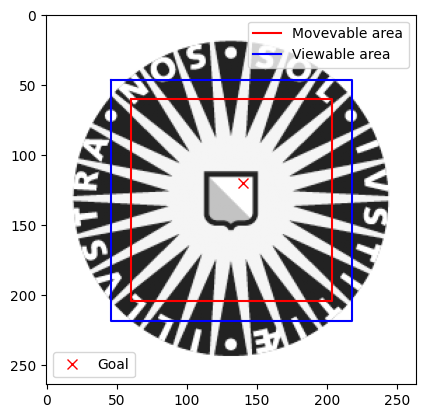

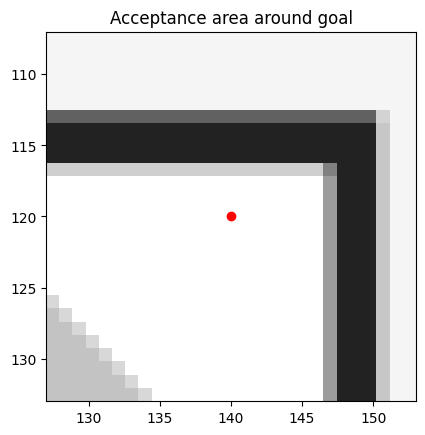

In [3]:
plt.imshow(IMAGE[:, :], cmap='gray', vmin=0, vmax=1.0)
# Plotting uses reversed y-axis now: larger y values are further down
goal_container = plt.plot(GOAL[0], GOAL[1], 'rx', markersize="7")
legend2 = plt.legend(goal_container, ["Goal"], loc=3)

plt.plot([Boundary.WEST, Boundary.WEST, Boundary.EAST, Boundary.EAST, Boundary.WEST],
         [Boundary.NORTH, Boundary.SOUTH, Boundary.SOUTH, Boundary.NORTH, Boundary.NORTH],
         'r-',
         label="Movevable area")
plt.plot([AugmentedArea.WEST, AugmentedArea.WEST, AugmentedArea.EAST, AugmentedArea.EAST, AugmentedArea.WEST],
         [AugmentedArea.NORTH, AugmentedArea.SOUTH, AugmentedArea.SOUTH, AugmentedArea.NORTH, AugmentedArea.NORTH],
         'b-',
         label="Viewable area")

plt.legend()
plt.gca().add_artist(legend2)
plt.show()

# window around goal
img_container = plt.imshow(get_window(GOAL),
                           cmap='gray',
                           vmin=0,
                           vmax=1.0,
                           extent=(GOAL[0] - ACCEPTABLE_DISTANCE_TO_GOAL, GOAL[0] + ACCEPTABLE_DISTANCE_TO_GOAL,
                                   GOAL[1] + ACCEPTABLE_DISTANCE_TO_GOAL, GOAL[1] - ACCEPTABLE_DISTANCE_TO_GOAL))
plt.plot(GOAL[0], GOAL[1], 'ro', linewidth=1)
plt.title("Acceptance area around goal")
plt.show()



The following class provides the functionality of tile encoding. The implementation can be used to define multiple tilings. The default code uses three tilings. You can play with different number of tilings, but please deliver the results with only one setting with multiple tilings.  


Samples:
[[246.99684921 168.91463549]
 [250.91737536 230.25349805]
 [244.81370725 195.9988778 ]
 [ 18.27856221 180.00098486]
 [ 91.15264121  29.5339802 ]]

Indexes of samples:
[[np.int64(8), np.int64(7)], [np.int64(8), np.int64(6)], [np.int64(8), np.int64(6)]]
[[np.int64(8), np.int64(8)], [np.int64(8), np.int64(8)], [np.int64(8), np.int64(8)]]
[[np.int64(8), np.int64(8)], [np.int64(8), np.int64(8)], [np.int64(8), np.int64(8)]]
[[np.int64(0), np.int64(8)], [np.int64(0), np.int64(6)], [np.int64(0), np.int64(7)]]
[[np.int64(2), np.int64(0)], [np.int64(0), np.int64(0)], [np.int64(3), np.int64(0)]]


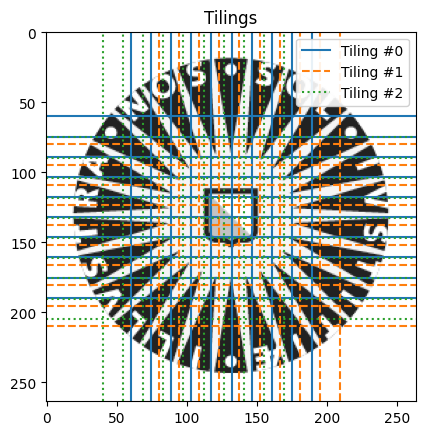

In [4]:
class grid_tilings():
    def __init__(self, number_of_grids = 1, offsets = np.array([[0.0, 0.0]]), bins_per_dim = (9, 9)) -> None:
        # Low value for each dimension, for each grid / tile
        lows = np.array([[Boundary.NORTH, Boundary.WEST]]*number_of_grids)
        # High value for each dimension, for each grid / tile
        highs = np.array([[Boundary.SOUTH, Boundary.EAST]]*number_of_grids)
        # Number of discrete bin for each each dimension, for each grid / tile
        bins = np.array([bins_per_dim] * number_of_grids)
        # The offset is used to setup the overlap of grids
        # offsets = np.array([[0.0, 0.0]]) is one grid starting from lows to highs 
        # offsets = np.array([[20.0, 20.0]]) is one grid starting from lows+[20.0, 20.0] to highs+[20.0, 20.0]

        self.grids = []

        for l, h, b, o in zip(lows, highs, bins, offsets):
            grid = {}
            grid['size']  = b
            grid['low'] = l
            grid['offset'] = o
            grid['points'] = []
            grid['step'] = []
            for dim in range(len(b)):
                points, step = np.linspace(l[dim], h[dim], b[dim]+1, endpoint=False, retstep=True)
                points += o[dim]
                grid['points'].append(points)
                grid['step'].append(step)

            grid['step'] = np.array(grid['step'])
            grid['weights'] = np.zeros(grid['size'])
            self.grids.append(grid)

    # Get the sum of the weights for given continuous coordinates
    def get_weight(self, sample):
        encoded_sample = self.tile_encode(sample)
        w = 0.0
        for grid, (x,y) in zip(self.grids, encoded_sample):
            w += grid['weights'][x,y]
        return w
    
    # Set the weights for given continuous coordinates
    def set_weight(self, sample, target):
        encoded_sample = self.tile_encode(sample)
        for grid, (x,y) in zip(self.grids, encoded_sample):
            grid['weights'][x,y] = target/len(self.grids)

    # Return the discrete coordinates from continuous coordinates for all grids
    def tile_encode(self, sample):
        encoded_sample = []
        for grid in self.grids:
            encoded_sample.append(self.discretize(sample, grid))
        return encoded_sample    
    
    # Return the discrete coordinates from continuous coordinates for a given grid
    def discretize(self, sample, grid):
        sample = np.array(sample) - (grid['low'] + grid['offset'])
        sample = np.maximum(sample, np.array([0]*len(grid['size'])))
        index = sample // grid['step']
        index = np.minimum(index, grid['size']-1)
        return list(index.astype(int))

    # Plot the different grids
    def visualize_tilings(self):
        """Plot each tiling as a grid."""
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        linestyles = ['-', '--', ':']
        legend_lines = []
        
        for i, grid in enumerate(self.grids):
            for x in grid['points'][0]:
                l = plt.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
            for y in grid['points'][1]:
                l = plt.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
            legend_lines.append(l)
        plt.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
        plt.title("Tilings")


# default setting for 3 tilings:
offsets = np.array([[0.0, 0.0], [20.0, 20.0], [-20.0, 15.0]])
tilings = grid_tilings(3, offsets)

# example for one tiling
# tilings = grid_tilings()

plt.imshow(IMAGE[:, :], cmap='gray', vmin=0, vmax=1.0)
tilings.visualize_tilings()

# Test with some sample values
samples = np.random.rand(5, 2) * 264
print("\nSamples:", samples, sep="\n")
encoded_samples = [tilings.tile_encode(sample) for sample in samples]
print("\nIndexes of samples:", *[s for s in encoded_samples], sep="\n")

 The following functions complete the definition of the environment. The agent's movements always go in the intended direction, but the distance travelled has a small random component. Besides by reaching the goal, the episode also terminates after TIME_LIMIT (200) steps; at that point, the agent gets a negative reward TIMEOUT_REWARD.

In [5]:
class Environment(gymnasium.Env):
    metadata = {'render.modes': ['human', 'rgba_array']}
    bx = np.array([AugmentedArea.WEST, AugmentedArea.WEST, AugmentedArea.EAST, AugmentedArea.EAST, AugmentedArea.WEST])
    by = np.array([AugmentedArea.NORTH, AugmentedArea.SOUTH, AugmentedArea.SOUTH, AugmentedArea.NORTH, AugmentedArea.NORTH])

    def __init__(self):
        self.num_actions = Actions
        self.action_space = spaces.Discrete(len(self.num_actions))
        self.observation_space = spaces.Discrete(1)
        self.display = None
        self.img, self.img_container = Environment._init_visual_area(IMAGE)
        self.time = 0

    def seed(self, seed=None) -> int:
        np.random.seed(seed)
        return seed

    def step(self, action: Actions):
        assert self.action_space.contains(action)
        (x, y), was_invalid = self._validate_state(self._move(self.state, action))

        self.state = (x, y)
        reward = MOVE_REWARD if not was_invalid else INVALID_MOVE_REWARD
        reward = TIMEOUT_REWARD if self.time >= TIME_LIMIT else reward
        reward = self.time * reward
        done = is_goal_reached(self.state) or self.time >= TIME_LIMIT
        self.time += 1
        return self.state, reward, done, {}

    def reset(self, state: State = None) -> State:
        self.state = self.starting_state() if not state else state
        self.time = 0
        return self.state

    # returns the current environment situation
    def render(self, mode='rgba_array'):
        curr_img = np.array(self.img_container.get_array())
        x, y = self.state
        scaler = 4
        w, e, n, s = x - scaler, x + scaler, y - scaler, y + scaler
        curr_img[n:s, w:e, 0] = 255
        curr_img[n:s, w:e, 1] = 0
        curr_img[n:s, w:e, 2] = 255
        curr_img[n:s, w:e, 3] = 255
        cropped_img = curr_img  # Just for debugging purposes
        if mode == 'rgba_array':
            plt.close()
            return cropped_img  # return RGB frame suitable for video
        elif mode == 'human':
            container = plt.imshow(curr_img)
            ax = container.axes
            ax.set_xlim(Boundary.WEST, Boundary.EAST, auto=None)
            ax.set_ylim(Boundary.SOUTH, Boundary.NORTH, auto=None)
            return container
        else:
            raise Exception(f"Please specify either 'rgba_array' or 'human' as mode parameter!")

    # Return a randomly chosen non-terminal state as starting state
    def starting_state(self) -> State:
        while True:
            state = (
                np.random.randint(Boundary.WEST, Boundary.EAST + 1),
                np.random.randint(Boundary.NORTH, Boundary.SOUTH + 1),
            )
            if not is_goal_reached(state):
                return state

    @staticmethod
    def _move(state: State, action: Actions) -> State:
        x, y = state
        if action == Actions.NORTH:
            y -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.SOUTH:
            y += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.WEST:
            x -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.EAST:
            x += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        return x, y

    @staticmethod
    def _validate_state(state: State) -> Tuple[State, bool]:
        x, y = state
        is_invalid = False
        if y < Boundary.NORTH:
            is_invalid = True
            y = int(Boundary.NORTH)
        if y > Boundary.SOUTH:
            is_invalid = True
            y = int(Boundary.SOUTH)
        if x < Boundary.WEST:
            is_invalid = True
            x = int(Boundary.WEST)
        if x > Boundary.EAST:
            is_invalid = True
            x = int(Boundary.EAST)
        return (x, y), is_invalid

    @staticmethod
    def _init_visual_area(img) -> np.ndarray:
        x, y = img.shape
        my_dpi = 80
        fig = Figure(figsize=(y / my_dpi, x / my_dpi), dpi=my_dpi)
        canvas = FigureCanvasAgg(fig)
        ax = fig.gca()

        ax.plot(GOAL[0], GOAL[1], 'ro', linewidth=5)
        ax.plot(Environment.bx, Environment.by, 'b-')
        img_container = ax.imshow(img[:, :], cmap='gray', vmin=0, vmax=1.0)
        ax.axis('off')
        fig.tight_layout()
        canvas.draw()  # draw the canvas, cache the renderer
        s, (width, height) = canvas.print_to_buffer()
        image = np.frombuffer(s, np.uint8).reshape((height, width, 4))
        img_container.set_data(image)
        plt.close()
        return image, img_container



### 2. Implement your agent for Semi-gradient SARSA and Q-Learning

Next comes your part. We start with integrating the linear approximation function with Tabular RL methods. 

**2.1** The following class is responsible for the agent's behavior. The select_action function should implement the epsilon-greedy policy, and return an action chosen according to that policy. **Please fill in the missing codes in select_action function (1.5 points).** 

 Remark: This is an abstract class.
 Hence, its sole purpose is creating subclasses from it, which is also the reason it cannot be instantiated.
 The following subsequent subclasses will provide a specific implementation for the methods that are missing here.
 Therefore, you can ignore the functions that are not implemented. This is just a common way to make sure that all subclasses behave similarly.

In [ ]:
class Agent(ABC):
    def __init__(self, alpha: float, gamma: float, epsilon: float):
        # set up the value of epsilon
        self.alpha = alpha  # learning rate or step size
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.hist = []

    # Choose action at state based on epsilon-greedy policy and valueFunction
    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = True) -> int:
        best_actions = []
        if(not use_greedy_strategy and np.random.rand() < self.epsilon): 
            best_actions.append(np.random.choice(list(Actions)))
        else:
            action_values = self.values(state)
            max_value = np.max(action_values)
            best_actions.append(np.where(action_values == max_value)[0])
        self.hist.append(self.values(state))
        return int(np.random.choice(best_actions))

    # Return estimated action value of given state and action
    @abstractmethod
    def value(self, state: State, action: Actions) -> float:
        pass

    # Return vector of estimated action values of given state, for each action
    @abstractmethod
    def values(self, state: State) -> np.ndarray:
        pass

    # Set value for given state and action
    @abstractmethod
    def set_value(self, state: State, action: Actions):
        pass
    
    # learn with given state, action and target
    # different between on-policy and off-policy
    @abstractmethod
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False) -> int:
        return None

    # Return estimated state value, based on the estimated action values
    def state_value(self, state):
        return np.max(self.values(state))

    # Plot the state value estimates. Use a larger stride for lower resolution.
    def plot_state_values(self, stride=1):
        self.v = np.zeros(
            ((Boundary.SOUTH - Boundary.NORTH + stride) // stride, (Boundary.EAST - Boundary.WEST + stride) // stride))
        for j, x in enumerate(range(Boundary.WEST, Boundary.EAST + 1, stride)):
            for i, y in enumerate(range(Boundary.NORTH, Boundary.SOUTH + 1, stride)):
                self.v[i, j] = self.state_value((x, y))

        plt.imshow(self.v)
        plt.colorbar()
        return plt.show()

    def plot_q_values(self, skip=1):
        return pd.DataFrame(self.hist[::skip]).plot()



**2.2** The next classes are two agents using either episodic semi-gradient Q-Learning and episodic semi-gradient SARSA algorithm to estimate the value function. Both agents use the same linear function approximation method with tile coding. **Implement the `learn` function according to the update rule for the respective algorithm (1 point for each)**. 
 
 REMARK: Both agents use the same tile coding. This method helps splitting the state-space into discrete chunks. Each chunk is associated with one weight.

In [7]:
# This class handles the function approximation, with several methods to query and update it. 
# A linear approximation function is used, making the computation much faster.
class QAgent(Agent):
    def __init__(self, alpha: float, gamma: float, epsilon: float, num_tilings: int = 3, bins_per_dim: tuple = (9, 9)):
        super().__init__(alpha, gamma, epsilon)
        # Use a tile coding
        offsets = np.array([[0.0, 0.0], [20.0, 20.0], [-20.0, 15.0]])

        self.tilings = [grid_tilings(number_of_grids=num_tilings, bins_per_dim=bins_per_dim) for a in Actions]

    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.tilings[action].get_weight(state)

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return [self.tilings[action].get_weight(state) for action in Actions]
    
    # Set value for given state and action
    def set_value(self, state: State, action: Actions, value: float):
        self.tilings[action].set_weight(state, value)
    
    # learn with given state, action and target
    # different between on-policy and off-policy: for Qlearning, the agent does not need to return the next selected action
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        old_q = self.value(state, action)
        target = reward + (0 if done else self.gamma * self.state_value(next_state))
        new_q = old_q + self.alpha * (target - old_q)
        self.set_value(state, action, new_q)

In [13]:
class SARSAAgent(Agent):
    def __init__(self, alpha: float, gamma: float, epsilon: float, num_tilings: int = 3, bins_per_dim: tuple = (9, 9)):
        super().__init__(alpha, gamma, epsilon)

        # Use a tile coding
        self.tilings = [grid_tilings(number_of_grids=num_tilings, bins_per_dim=bins_per_dim) for a in Actions]

    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.tilings[action].get_weight(state)

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return [self.tilings[action].get_weight(state) for action in Actions]

    # Set value for given state and action
    def set_value(self, state: State, action: Actions, value: float):
        self.tilings[action].set_weight(state, value)
    
    # learn with given state, action and target
    # different between on-policy and off-policy: for SARSA, the agent needs to return the next selected action
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        old_q = self.value(state, action)
        target = reward + (0 if done else self.gamma * self.value(next_state, self.select_action(next_state, False)))
        new_q = old_q + self.alpha * (target - old_q)
        self.set_value(state, action, new_q)
        return self.select_action(next_state, False)
        


 The following function handles the interaction between agent and environment for a single episode. By passing the same value_function object in multiple calls to this function, the agent can learn from a sequence of such interactions.

 **Please fill in the missing parts (1 point).** 

In [ ]:
# env: Environment in which the agent is supposed to run 
# agent: agent to learn
# initital state: Starting state for the environment
# is_learning: should the value function be updated during the simulation?
# is_rendering: should the run be recorded? (Takes some time to compute)


def run_episode(env: Environment,
                agent: Agent,
                initial_state: State,
                is_learning: bool = True,
                is_rendering: bool = False) -> Tuple[State, float]:
    # Initialize reward for episode
    total_reward = 0.0
    # Initialize the policy (if is_greedy=True then the agent follows its optimal policy, otherwise it will randomly select an action)
    is_greedy = not is_learning
    # Get initial action
    current_state = initial_state
    current_action = agent.select_action(initial_state, use_greedy_strategy=is_greedy)

    # Track the rendering
    animation_data = []
    animation_data.append((env.render(), env.time, None, current_state, None, 0))
    # Initialize variables
    next_state = None
    done = False
    next_action = None
    while not done:
        # TO BE FILLED
        next_state, reward, done, _ = env.step(current_action)

        total_reward += reward
        if is_rendering:
            curr_img = env.render()
            animation_data.append((curr_img, env.time, current_state, next_state, current_action, total_reward))
        
        # Execute the learning and update the state and action
        if is_learning:
            if isinstance(agent, SARSAAgent):
                next_action = agent.learn(current_state, current_action, next_state, reward, done)
            else:
                agent.learn(current_state, current_action, next_state, reward, done)
        current_state = next_state
        current_action = next_action if isinstance(agent, SARSAAgent) else agent.select_action(current_state, use_greedy_strategy=is_greedy)        
   # agent.last_action = None
    return current_state, total_reward, animation_data


 To help understand your agent, you can render the agent's performance by setting render to True and running the `run_epoch` function. 
 
 There are some helper functions. They might help you implement the agent correctly. 
 * `agent.plot_state_values` shows you how the agent values different states
 * `agent.plot_q_values` shows the q_values that the agent had over the course of his life time. (That could be a lot. There's a skip parameter to reduce the amount of data points)

 REMARK: Keep in mind, the following is just one example run. Don't expect the model to be fully trained after just one episode. The training part follows in the next section.

(76, 163)
(131, 108)


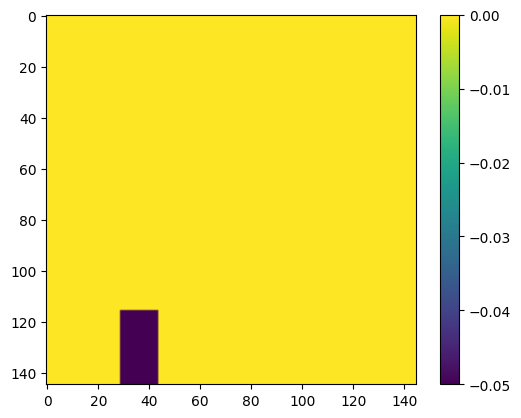

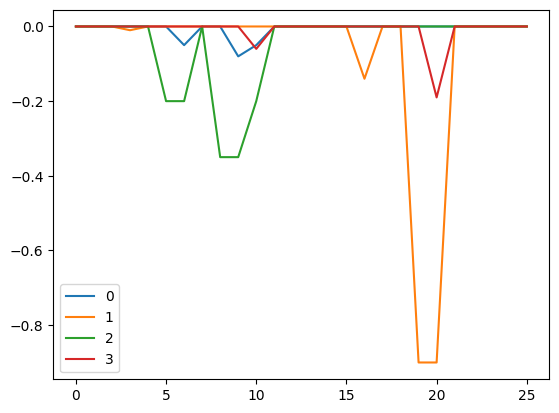

In [25]:
env = Environment()
epsilon = 0.0
gamma = .7
alpha = 1e-2
agent = QAgent(alpha, gamma, epsilon)
start_state = env.reset()
print(start_state)
end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning=True, is_rendering=True)
print(end_state)
agent.plot_state_values()
agent.plot_q_values(skip=1)
render_epoch(animation_data, interval=100)

### 3. Run the simulation, play with parameters and analyse results

 Now it's time to train both algorithms/agents on the environment. 
 
 In the simulations, please plot the measure of each algorithm's performance as a function of the episode (i.e. the sum of all immediate rewards received in each episode). You shall play with a few combinations of two parameters discount factor $\gamma$ and stepsize $\alpha$ (at least two variables for each parameter). During the experiments, keep $\epsilon$ fixed at $0.01$. A reasonable starting point for $\alpha$ is 1e-2. 
 
 REMARK: You can save the parameters and update-to-date Q table of each agent, so that you can still test their performance later. (You can achieve this by keeping the object.)
 

**3.1 Please submit your code as well as the plots presenting compariable performance of the different combinations of parameters for every algorithms (2 points)**. 

REMARK: For a decent comparison all agents should be plotted on the same axis bounds. Also, the plots may be hard to interpret because of the scales. Feel free to do your own smoothing or use the `smooth` function provided in the beginning.

In [26]:
# Your code here for running the simulation and ploting the sum of immediate reward in each episode.

# Init the environment and run Q-Learning & SARSA

# Save and plot the results

# TO BE FILLED.
env = Environment()
epsilon = 0.01
gamma = .7
alpha = 1e-2
agent = SARSAAgent(alpha, gamma, epsilon)
for episode in tqdm(range(9)):
    start_state = env.reset()
    end_state, total_reward, _ = run_episode(env, agent, start_state, is_learning=True, is_rendering=False)
start_state = env.reset()
print(start_state)
end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning=False, is_rendering=True)
print(end_state)
agent.plot_state_values()
agent.plot_q_values(skip=1)
render_epoch(animation_data, interval=100)




100%|██████████| 9/9 [00:00<00:00, 76.21it/s]

(181, 151)


AssertionError: 

Put your plots here. (In case your code takes too long to run.) 

**3.2 Please interpret the results/plots (2 points)**. 

Explain what the results say about the parameters alpha (learning rate) and gamma (decay-rate), and their effects on learning.

**3.3 Let us think one step further by looking at the policies you have learned (1.5 points).** 

Please compare the performance of your learned optimal policies using another simulation. In this simulation, you shall have three agents (Qlearning_Agent, SARSA_agent and Random_agent), where all three agents always use their learned policy to behave and find the goal in the given map (make sure the agent does NOT learn anymore!). The initial policies of Qlearning_Agent and SARSA_agent are the optimal policies learned from the above experiments (based on the final estimated Q-values using Q-Learning and SARSA algorithm respectively). The inital policy of Random_Agent will select 4 actions randomly. 

Describe the performance of three agents by running each agent on the task and discuss the results (1.5 points). You can use the render function provided above (and other helper functions) observe the different behaviors of three agents. You could also use an appropriate plot to show the different performances. **There is no need to submit your codes for this question.**

Some questions you shall think about and answer (in case there are no differences or no special things, just indicate what you observed):
- How does the learned Q-Learning policy and SARSA policy perform differently? Does it show the difference between on-policy and off-policy methods?
- What kind of strategy did the two RL agents learn similarly? How do they differ from the random policy?

### 4. Implement your agent for DQN
---

Now we want to implement an agent for a deep RL algorithm DQN, and compare it with the other two algorithms.

4.1 DQN uses two deep neural networks for training. A policy and a target network. Here we're defining the network architecture. You can just use the network as provided by us. But feel welcome to play around with changing the number of nodes per layers, the activation functions or the layers themselves. However, whether you play with the network or not will not affect your grade.

In [13]:
# Provided DQN Architecture
# PyTorch Q-network skeleton

class QNetwork(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions)
        )
        
    def forward(self, x):
        return self.net(x)


**4.2 Replay Buffer (0.5 points)**

In DQN, we use a replay buffer. The Replay Buffer stores and manages experiences (state, action, reward, next_state, done[has terminated]) so the agent can learn from them multiple times.

You will implement two methods:
  - push method to store an experience in the buffer
  - sample method to return a batch of experiences, i.e., (states, actions, rewards, next_states, dones)

In [14]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    # push a transition to the memory (buffer)
    def push(self, state, action, reward, next_state, done):
        # TO BE FILLED.

    # randomly sample a batch of consecutive experiences; please convert to numpy array for later training
    def sample(self, batch_size):
        # TO BE FILLED.

    def __len__(self):
        return len(self.buffer)

IndentationError: expected an indented block after function definition on line 7 (3198315279.py, line 11)

While DQN can learn from continuous features, in our target task, learning from just x and y coordinate makes DQN very data hungry. To decrease the training load, we use a Radial Basis Function to embed the x and y coordinates. A Radial Basis Function transforms a distance to a value between 0 and 1 (with 1 meaning the distance is 0 and 0 meaning the distance is infinity). We use 9 points sampled across the input space as references and transform a position (x,y) into a vector containing 9 values between 0 and 1 by using the Gaussian kernel to transform distances.

In this way, we are enriching the feature and transforming a 2D input into a 9D input with continuous and smooth values. There is no need to implement this function. Please use this function to embed the states before feeding them to DQN. This enables DQN to learn faster with fewer data. 

REMARK: Using a Radial Basis Function to embed the 2D coordinates as a similar approach to using a CNN to embed an image. This will not be covered in the exams!


In [ ]:

# --- Define RBF Hyperparameters ---
N_CENTERS_PER_DIM = 3 # This will create 3x3 = 9 centers
RBF_STATE_DIM = N_CENTERS_PER_DIM * N_CENTERS_PER_DIM # New state_dim = 9

X_RANGE = Boundary.EAST - Boundary.WEST
Y_RANGE = Boundary.NORTH - Boundary.SOUTH

# Create a 3x3 grid of centers
x_centers = np.linspace(Boundary.WEST + X_RANGE/4, Boundary.EAST - X_RANGE/4, N_CENTERS_PER_DIM)
y_centers = np.linspace(Boundary.SOUTH + Y_RANGE/4, Boundary.NORTH - Y_RANGE/4, N_CENTERS_PER_DIM)

# Create a 9x2 array of (x, y) center coordinates
RBF_CENTERS = np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)


# Define the "width" of the gaussian kernels
RBF_SIGMA = (X_RANGE / N_CENTERS_PER_DIM) * 0.5

print(f"Using {RBF_STATE_DIM} RBF features (centers) with sigma={RBF_SIGMA:.2f}")

# --- RBF embedding function ---
def embed_state_rbf(state):
    """
    Calculates the 'closeness' (Gaussian) to each RBF center.
    """
    state_vec = np.array(state, dtype=np.float32) # [x, y]

    # Calculate squared distance from state to centers
    sq_distances = np.sum((state_vec - RBF_CENTERS)**2, axis=1)

    # Apply the Gaussian (bell curve) formula
    # exp(-dist^2 / (2 * sigma^2))
    features = np.exp(-sq_distances / (2 * RBF_SIGMA**2))

    return features.astype(np.float32)

Using 9 RBF features (centers) with sigma=24.00


**4.3: DQN** 

Now you are ready to define the DQN agent.
Please implement the following methods (**2 points**):

- select_action
- learn
- run_episode_dqn

Note that you should use the embed_state_rbf() method to embed states.

In [ ]:
class DQNAgent(Agent):
    def __init__(self, state_dim, n_actions, gamma, epsilon_start, epsilon_end, epsilon_decay, learning_rate, buffer_size, batch_size, target_update_freq):
        # Note: We pass learning_rate as 'alpha' and epsilon_start as 'epsilon'
        # state_dim : dimension of the (embedded) input space
        # n_action : number of actions the agent can take
        # gamma: discount factor
        # epsilon_end: we will decrease epsilon over time, epsilon_end is the minimal epsilon value
        # epsilon_decay: how much we will decrease epsilon with each update
        # batch_size: how many consecutive are use for one training update
        # target_update_freq: the frequency with which the target net is updated
        super().__init__(alpha=learning_rate, gamma=gamma, epsilon=epsilon_start)

        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.policy_net = QNetwork(state_dim, n_actions).to(self.device)
        self.target_net = QNetwork(state_dim, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayBuffer(self.buffer_size)

        self.steps_done = 0
        self.episode_rewards = []

    def __del__(self):
        # Clean up CUDA memory if used
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()

    def values(self, state):
        # Gets Q-values for a state that is embedded.
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values_tensor = self.policy_net(state_tensor)
            return q_values_tensor.cpu().numpy().flatten()

    def value(self, state, action):
        # Get Q-value for a specific state-action pair
        q_values = self.values(state)
        return q_values[action]


    def set_value(self, state: State, action: Actions, value: float):
        # This method is for tabular agents, not directly applicable to DQN
        # We can't directly set a weight for a single state-action pair
        pass

    # Choose an action for the given state.
    # Returns the choosen action
    def select_action(self, state, use_greedy_strategy=False):
        # TO BE FILLED.

    # This function takes in a transition and saves it to the memory.
    # Note that you can only learn, if the memory has at least as many saved experiences as the batch size.
    # Think carefully about the roles of the target and the policy network and when to update which
    # You should use torch.nn.MSELoss() to compute the loss, and the optimizer that is part of the agent (self.optimizer)
    def learn(self, state, action, reward, next_state, done):

        # TO BE FILLED.

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)

        return None


    def state_value(self, state):
        """
        Returns the state-value V(s) = max_a Q(s,a)
        Used by Agent.plot_state_values()
        """
        q = self.values(state)
        return float(np.max(q))

    def plot_state_values(self, stride=1):
        self.v = np.zeros(
            ((Boundary.SOUTH - Boundary.NORTH + stride) // stride, (Boundary.EAST - Boundary.WEST + stride) // stride))
        for j, x in enumerate(range(Boundary.WEST, Boundary.EAST + 1, stride)):
            for i, y in enumerate(range(Boundary.NORTH, Boundary.SOUTH + 1, stride)):
                self.v[i, j] = self.state_value(embed_state_rbf((x, y)))

        plt.imshow(self.v)
        plt.colorbar()
        return plt.show()


In [ ]:
# This method is what you may use to train the agent for one episode. You need to set-up the environment. 
# Until the episode terminates the agent should interact with the environment. 
# is_learning and is_rendering indicate if the agent should also learn (update weights) and if the data for antimating the episode should be collected and returned. 
# In that case make sure to save env.render(), env.time, the previous state, the new state, the choosen action and the total reward for every timestep.

def run_episode_dqn(env, agent, is_learning=True, is_rendering=False):
    state = env.reset()
    state = np.array(state, dtype=np.float32)
    state = embed_state_rbf(state) # embed state
    total_reward = 0.0
    done = False
    animation_data = []

    if is_rendering:
        animation_data.append((env.render(), env.time, None, state, None, 0))

    while not done:
        # TO BE FILLED.

    return total_reward, animation_data # Return total_reward

**4.4 Run the simulation, play with parameters and analyse results (1 point)**

Now it's time to train and evaluate DQN algorithm/agent on the environment. 
Similar with the other two algorithms, in the simulations, please plot the measure of DQN's performance. 
You shall play with two parameters: stepsize (learning rate) $\alpha$ and update frequency of target network ($c$ in the slides), and find good values for them. During the experiments, you can stick with the values provided below for the remaining hyperparameters.

There is no need to submit your code for this answer. Please provide the final plots of learning performance for DQN with different parameters.

Tips: When training the DQN agent, you can use a warm-up stage to fill up the memory of this agent with experiences (following the random policy) to speed up the training process. You may also plot the state values to see how the agent learns over time.


In [ ]:
num_episodes_dqn = 4000
gamma_dqn = 0.99
epsilon_start_dqn = 1.0
epsilon_end_dqn = 0.05
epsilon_decay_dqn = (epsilon_start_dqn - epsilon_end_dqn) / (num_episodes_dqn * 0.9) # Decay over 90% of episodes

buffer_size_dqn = 10000
batch_size_dqn = 64

num_seed_dqn = 42

# To be played with, and fill in your final setting, please notice your below results shall follw these two parameters
learning_rate_dqn = ?
target_update_freq_dqn = ?


SyntaxError: invalid syntax (1792643383.py, line 14)

Please add your final plots here and explain your observations. 

**4.5 Finally, let us compare DQN with Semi-gradient SARSA and Q-learning (1.5 points)**

We require you to train all three algorithms together, compare their learning processes and explain the final learned policies.

**You do not need to submit your code for this question**. Please provide one plot that shows the learning curves of all three algorithms, and then explain your observations. To understand the learned policy, please use the code below to visualize the learned policy for agents, explaining the learned policy and arguing whether it is optimal.

Some questions you shall think about and answer (in case there are no differences or no special things, just indicate what you observed):
- How do the learning procedures of the three algorithms differ?
- What strategy does each RL agent appear to have learned? How is the final learned policy of the three algorithms different (or similar)? - When do we use different algorithms?


Put your plots for the learning procedure and final learned policies here.


Explain your answers. 

Here are the codes you can use to visualize the learned policy. For each possible state, the greedy policy is visualized.


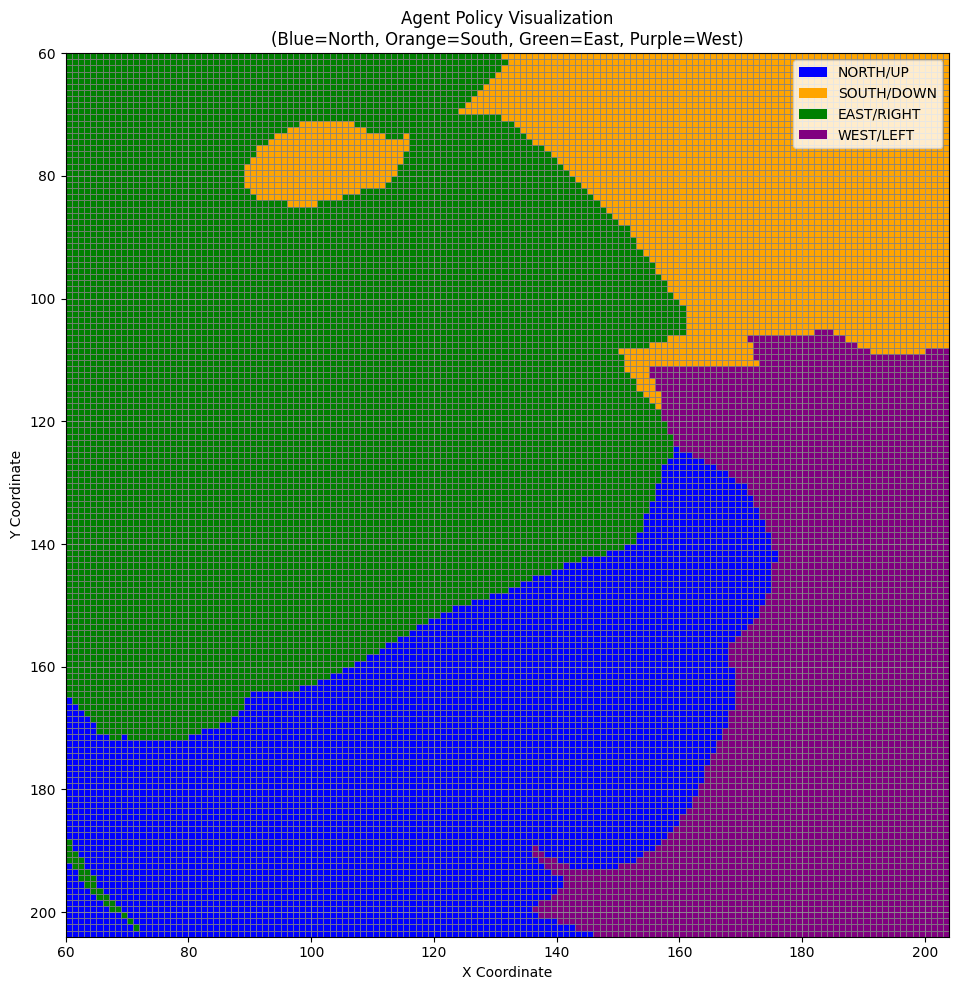

In [ ]:
def plot_agent_policy(agent, stride=1, dqn_agent=True):

    # Plot the agent's policy for each state in the grid.

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Prepare the grid
    x_coords = range(60, 205, stride)
    y_coords = range(60, 205, stride)

    # Create arrays to store actions and colors
    action_grid = np.zeros((len(y_coords), len(x_coords)), dtype=int)
    color_grid = np.empty((len(y_coords), len(x_coords)), dtype=object)

    # Map actions to colors
    action_colors = {
        Actions.NORTH: 'blue',    # NORTH = BLUE
        Actions.SOUTH: 'orange',     # SOUTH = ORANGE
        Actions.EAST: 'green',        # EAST = GREEN
        Actions.WEST: 'purple'       # WEST = PURPLE
    }

    # For each state, get the greedy action
    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            # Embed the state
            if dqn_agent:
                embedded_state = embed_state_rbf((x, y))
            else:
                embedded_state = (x,y)

            # Get greedy action
            action = agent.select_action(embedded_state, use_greedy_strategy=True)

            action_grid[i, j] = action
            color_grid[i, j] = action_colors[action]

    # Create the plot
    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            ax.add_patch(plt.Rectangle((x, y), stride, stride,
                                     facecolor=color_grid[i, j],
                                     edgecolor='gray',
                                     linewidth=0.5))

    # Set plot properties
    ax.set_xlim(60, 204)
    ax.set_ylim(204, 60)
    ax.set_aspect('equal')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Agent Policy Visualization\n(Blue=North, Orange=South, Green=East, Purple=West)')

    # Create legend

    legend_elements = [
        Patch(facecolor='blue', label='NORTH/UP'),
        Patch(facecolor='orange', label='SOUTH/DOWN'),
        Patch(facecolor='green', label='EAST/RIGHT'),
        Patch(facecolor='purple', label='WEST/LEFT')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.show()

plot_agent_policy(agent, stride=1)

Well done! Before handing in, make sure that the code you hand in work, and that all plots are shown. 

Again, please name this file according to your last names.